# Genetic Algorithm to solve the D-EVRP-NL
This notebook allows you to work with the implemented library and solve the Dynamic Electric Vehicle Routing Problem with Non-linear charging functions. The main purpose is to give good visualization of the solution and easy handling of network complexity.

## Initialization

First, import required libraries.

In [1]:
# Too work with arguments and script paths
import sys

# scientific libraries and tutilities
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

# setup pyplot
conf = {'font.size': 20}
plt.rcParams.update(conf)

# GA library
from deap import base
from deap import creator
from deap import tools

# Visualization tools
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.layouts import row as layout_row
from bokeh.models.annotations import Arrow, Label
from bokeh.models.arrow_heads import OpenHead, NormalHead, VeeHead
from bokeh.models import ColumnDataSource, Div, Whisker, Span, Range1d
from bokeh.io import export_svgs, export_png

# Simulation environment tools
sys.path.append('..')
import res.EV_utilities
import res.GA_utilities_1

# Display useful loading of bokeh library and start timer
output_notebook()
t0 = time.time()

Loading BokehJS ...

The following are user-defined variables

In [2]:
# Network size and where are data files stored
networkSize = 70
folderPath = '../data/GA_implementation/'

# Charging stations points
chargingTimePoints = True
timePoints = [0.0, 40.0, 60., 120.]
socPoints = [0.0, 75.0, 90.0, 100.0]

# figure related
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 500

figureFolderPath = "../data/GA_implementation/"+str(networkSize)+"network/"

The following implements some utility functions, not related to main GA

In [3]:
# %% Utilities
def shapeItems(items, shape=(None, 2)):
    numOfItems = len(items)
    columns = shape[1]

    if shape[0] is None:
        rows = int(numOfItems / columns) + int(numOfItems % columns)
    else:
        rows = shape[0]

    gridList = [[None] * columns for _ in range(0, rows)]

    i = 0
    j = 0
    for fig in items:
        if j == columns:
            i += 1
            j = 0
        gridList[i][j] = fig
        j += 1
    return gridList

## Import data
There are three main data files:
    - Time matrix: containing the time it takes to travel along arcs between each node
    - Energy matrix: cantaining the energy it takes to travel along arcs between each node
    - Info file: containing the information of each node

In [4]:
# %% Import time and energy matrices and show a value example

pathTM = folderPath + 'timeMatrix_' + str(networkSize) + 'nodes.csv'
timeMatrix = pd.read_csv(pathTM).set_index("TT(MIN)")

print('Time matrix:\n', timeMatrix, "\n")

pathEM = folderPath + 'energyMatrix_' + str(networkSize) + 'nodes.csv'
energyMatrix = pd.read_csv(pathEM).set_index("ENERGY(AH)")

print('Energy matrix:\n', energyMatrix, '\n')

# Indexing example
print("An index example...")
t = timeMatrix.iat[1, 2]
print("Travel time from 1 to 2: ", t)

e = energyMatrix.iat[1, 2]
print("Energy consumption from 1 to 2: ", e, '\n')


Time matrix:
                  0          1          2          3          4          5  \
TT(MIN)                                                                     
0         0.000000   8.356502  16.123209  14.836564  13.392616   9.867789   
1        14.960005   0.000000  13.535000  10.818365   8.083996  11.737020   
2        18.779469   8.607673   0.000000  19.689762   8.923815  10.009828   
3        19.752689  19.233880   8.754894   0.000000  12.713773  14.788688   
4        11.107851   9.119571  13.099216  15.048761   0.000000  11.073443   
5        13.569591  15.147919  15.652644  11.324876  15.046297   0.000000   
6        17.464498  10.461563  10.940352  11.138421  18.124205  19.835869   
7         8.545763  19.573603  10.955728  13.326397  12.548286   8.809506   
8        19.051816  19.126585  14.470572  10.025858  10.300224  14.314167   
9        19.708899  17.608126  19.607606  18.936274  15.412511   8.099018   
10       19.244528  16.888571   9.415239  17.135746  15.411688

In [5]:
# %% Import nodes information to differentiate among them

infoMatrix = pd.read_csv(folderPath + 'infoMatrix_' + str(networkSize) + 'nodes.csv')

depotDF = infoMatrix[infoMatrix['TYPE'] == 'DEPOT'].dropna(axis=1)
customerDF = infoMatrix[infoMatrix['TYPE'] == 'CUSTOMER'].dropna(axis=1)
csDF = infoMatrix[infoMatrix['TYPE'] == 'CS'].dropna(axis=1)

print('Depots DF:\n', depotDF, '\n')
print('Customers DF:\n', customerDF, '\n')
print('Charge Stations DF\n', csDF, '\n')


Depots DF:
    ID  POS_X  POS_Y   TYPE
0   0    0.0    0.0  DEPOT 

Customers DF:
     ID    DEMAND       POS_X       POS_Y  SERVICE_TIME  TIME_WINDOW_LOW  \
1    1  0.381097   14.813312  -29.273489      1.007486       678.736882   
2    2  0.408219  -97.029553   60.025620      2.248755       680.000000   
3    3  0.053798  -43.318305   69.830098      6.003728       623.356850   
4    4  0.233368   37.132541  133.453625      1.160810       697.072161   
5    5  0.302256  112.712082    0.849134      3.061553       629.976678   
6    6  0.461768  -64.212584 -109.112513      3.871720       600.470041   
7    7  0.487554 -102.013543  -66.565080      3.761231       605.271059   
8    8  0.096205  126.678949   54.553029      9.550936       611.281571   
9    9  0.220654  -37.589036   93.696398      2.562627       644.400828   
10  10  0.494580   64.787774   32.400054      7.623873       610.888516   
11  11  0.110390   31.492086  -36.891120      1.324521       651.483803   
12  12  0.191371 

## Create variables

In [6]:
# Create list with information

networkDict = {'DEPOT_LIST': [], 'CUSTOMER_LIST': [], 'CS_LIST': [],
               'TIME_MATRIX': timeMatrix, 'ENERGY_MATRIX': energyMatrix}

for _, row in depotDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.DepotNode(row['ID'])
    networkDict['DEPOT_LIST'].append(networkDict[row['ID']])

for _, row in customerDF.iterrows():
    networkDict[row['ID']] = res.EV_utilities.CustomerNode(row['ID'], row['SERVICE_TIME'], row['DEMAND'],
                                                           timeWindowUp=row['TIME_WINDOW_UP'],
                                                           timeWindowDown=row['TIME_WINDOW_LOW'])
    networkDict['CUSTOMER_LIST'].append(networkDict[row['ID']])

figureList = []

for _, row in csDF.iterrows():
    # Simple CS with linear curve
    if chargingTimePoints:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'],
                                                                    timePoints=timePoints,
                                                                    socPoints=socPoints)
    else:
        networkDict[row['ID']] = res.EV_utilities.ChargeStationNode(row['ID'])

    networkDict['CS_LIST'].append(networkDict[row['ID']])
    # Append to show as grid
    s = figure(width=400, height=250, title='Charging function of CS ' + str(networkDict[row['ID']].id))

    s.xaxis.axis_label = 'Time (min)'
    s.yaxis.axis_label = 'SOC (%)'
    s.line(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', line_width=2)
    s.asterisk(networkDict[row['ID']].timePoints, networkDict[row['ID']].socPoints, color='black', size=10)
    
    # Save
    s.output_backend = "svg"
    export_svgs(s, filename=figureFolderPath+"CS"+str(row['ID'])+"_chargingFunction.svg")
    
    figureList.append(s)

# show grid
shapedFigs = shapeItems(figureList, shape=(None, 2))
p = gridplot(shapedFigs, toolbar_location='left')
show(p)


## Assign customers to each EV

In [7]:
# %% Number of cars and their random set to visit. Ensure that each one of them visit at least one

t1 = time.time()

nVehicles = 10
chooseCustomersRandom = False

vehiclesDict = {}

if chooseCustomersRandom:
    # Choose the customers each vehicle will visit randomly
    customersID = [evID for evID in customerDF['ID']]
    nCustomers = len(customersID)
    nCustomersPerCar = [int(nCustomers / nVehicles)] * nVehicles

    if len(customersID) % nVehicles != 0:
        nCustomersPerCar[-1] = int(len(customersID) / nVehicles) + 1

    for i, j in enumerate(nCustomersPerCar):
        print('Car', i, 'must visit', j, 'customer/s')
    print('\n')

    for carId, nCustomersCar in enumerate(nCustomersPerCar):
        carCustomersId = []
        for j in range(0, nCustomersCar):
            index = random.randint(0, len(customersID) - 1)
            carCustomersId.append(customersID.pop(index))
        customersToVisit = [customerId for customerId in carCustomersId]
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        x1 = 24.0 * 30.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x1=x1, x2=Qi, x3=sumDi)
else:
    customersID = [[12, 26, 15, 17, 14, 59],
                   [66, 30, 36, 44, 45, 63],
                   [65, 57, 28, 33, 49, 31],
                   [61, 38, 42, 48, 25, 53],
                   [7, 34, 6, 58, 43, 37],
                   [3, 19, 35, 2, 18, 39],
                   [41, 10, 16, 56, 67, 29],
                   [24, 60, 23, 50, 32, 46],
                   [54, 51, 11, 9, 52, 62],
                   [55, 5, 1, 4, 40, 47, 21]]
    for i, l in enumerate(customersID):
        print('Car',i,'must visit', len(l),'customers')
        
    nCustomers = sum([len(x) for x in customersID])

    for carId, customersToVisit in enumerate(customersID):
        print('Car', carId, 'must visit customers with ID:', customersToVisit)

        # IMPORTANT: the proposed nodeSequence
        nodeSequence = [0] + customersToVisit + [0]
        chargingSequence = [0] * len(nodeSequence)

        # instantiate
        Qi = 80.0
        sumDi = np.sum([networkDict[i].demand for i in nodeSequence])
        vehiclesDict[carId] = res.EV_utilities.ElectricVehicle(carId, customersToVisit, networkDict,
                                                               nodeSequence=nodeSequence,
                                                               chargingSequence=chargingSequence,
                                                               timeMatrix=timeMatrix.iat,
                                                               energyMatrix=energyMatrix.iat,
                                                               x2=Qi, x3=sumDi)


Car 0 must visit 6 customers
Car 1 must visit 6 customers
Car 2 must visit 6 customers
Car 3 must visit 6 customers
Car 4 must visit 6 customers
Car 5 must visit 6 customers
Car 6 must visit 6 customers
Car 7 must visit 6 customers
Car 8 must visit 6 customers
Car 9 must visit 7 customers
Car 0 must visit customers with ID: [12, 26, 15, 17, 14, 59]
Car 1 must visit customers with ID: [66, 30, 36, 44, 45, 63]
Car 2 must visit customers with ID: [65, 57, 28, 33, 49, 31]
Car 3 must visit customers with ID: [61, 38, 42, 48, 25, 53]
Car 4 must visit customers with ID: [7, 34, 6, 58, 43, 37]
Car 5 must visit customers with ID: [3, 19, 35, 2, 18, 39]
Car 6 must visit customers with ID: [41, 10, 16, 56, 67, 29]
Car 7 must visit customers with ID: [24, 60, 23, 50, 32, 46]
Car 8 must visit customers with ID: [54, 51, 11, 9, 52, 62]
Car 9 must visit customers with ID: [55, 5, 1, 4, 40, 47, 21]


 ## Setup GA

In [8]:
# %% Genetic algorithm

# allowed charging operations
numChargeOp = 2

# Build toolbox and useful classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Individual initializer
toolbox.register("individual", res.GA_utilities_1.createRandomIndividual, vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Fitness, crossover, mutation and selection
toolbox.register("evaluate", res.GA_utilities_1.fitness, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mate", res.GA_utilities_1.crossover, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("mutate", res.GA_utilities_1.mutate, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("select", tools.selTournament, tournsize=3)

# Useful to decode
toolbox.register("decode", res.GA_utilities_1.decodeFunction, vehiclesDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)

# Constraint handling
toolbox.register("distance", res.GA_utilities_1.distanceToFeasibleZone, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.register("feasible", res.GA_utilities_1.feasibleIndividual, vehicleDict=vehiclesDict,
                 allowed_charging_operations=numChargeOp)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, -500000.0, toolbox.distance))

## Run GA

In [9]:
# %% the algorithm

tInitGA = time.time()
# Population TODO create function
n = 200
generations = 600

pop = []
for i in range(0, n):
    pop.append(creator.Individual(toolbox.individual()))

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.4, 0.4

print("################  Start of evolution  ################")

# Evaluate the entire population
# fitnesses = list(map(toolbox.evaluate, pop))

for ind in pop:
    fit = toolbox.evaluate(ind)
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0
Ymax = []
Ymin = []
Yavg = []
Ystd = []
X = []

bestOfAll = tools.selBest(pop, 1)[0]

# Begin the evolution
while g < generations:
    # A new generation
    g = g + 1
    X.append(g)
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        fit = toolbox.evaluate(ind)
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

    Ymax.append(-max(fits))
    Ymin.append(-min(fits))
    Yavg.append(mean)
    Ystd.append(std)

    bestInd = tools.selBest(pop, 1)[0]
    print("Best individual: ", bestInd)

    worstInd = tools.selWorst(pop, 1)[0]
    print("Worst individual: ", worstInd)

    # Save best ind
    if bestInd.fitness.values[0] > bestOfAll.fitness.values[0]:
        bestOfAll = bestInd

# %%
print("################  End of (successful) evolution  ################")


################  Start of evolution  ################
  Evaluated 200 individuals
-- Generation 1 --
  Evaluated 127 individuals
  Min -13652729.376894532
  Max -3992349.3590667783
  Avg -7284156.76789595
  Std 2126483.039201002
Best individual:  [14, 17, 26, 12, 59, 15, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, -1, 0, 10.0, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 828, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 992, 56, 41, 29, 10, 67, 16, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 1190, 51, 54, 62, 9, 52, 11, -1, 0, 10.0, -1, 0, 10.0, 221, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 891]
Worst individual:  [17, 59, 26, 12, 15, 14, -1, 0, 10.0, -1, 0, 10.0, 75, 45, 44, 30, 63, 36, 66, -1, 0, 10.0, -1, 0, 10.0, 1215, 31, 49, 65, 33, 57, 28, -1, 0, 10.0, -1, 0, 10.0, 1182, 42, 25, 53, 48, 38

  Evaluated 133 individuals
  Min -4090418.912350308
  Max -2556148.5607197266
  Avg -3866642.41033051
  Std 259510.35631383726
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, -1, 0, 10.0, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 992, 56, 41, 29, 10, 67, 16, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 377, 51, 54, 62, 9, 52, 11, -1, 0, 10.0, 52, 69, 37.26726402594219, 221, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 891]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, -1, 0, 10.0, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 

  Evaluated 131 individuals
  Min -2740633.5035427096
  Max -2155284.4532964136
  Avg -2484672.364667455
  Std 53763.01162582064
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 992, 67, 10, 16, 56, 41, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 377, 51, 54, 62, 9, 52, 11, -1, 0, 10.0, -1, 0, 10.0, 302.3262143092701, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 835.2950192650993]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 36, 66, 30, 44, 45, 63, 68, 15.41135332387333, -1, 0, 10.0, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, 48, 68, 75.50509855470845, -1, 69, 67.074

  Evaluated 128 individuals
  Min -2420514.3984811045
  Max -2000588.2960105718
  Avg -2199945.9995879256
  Std 64832.82911995485
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 992, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 377, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 302.3262143092701, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 835.2950192650993]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.

  Evaluated 132 individuals
  Min -2152023.4119985467
  Max -1849310.8474299384
  Avg -1960551.1911170692
  Std 42610.43316404148
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 992, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 428.02367084777154, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 302.3262143092701, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 802.7154444273351]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38,

  Evaluated 133 individuals
  Min -1963972.0327096449
  Max -1714070.4623470197
  Avg -1813252.5221202786
  Std 42300.33370210654
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45, 36, 30, 44, 63, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 68, 66.42007459961432, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 992, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 428.02367084777154, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 346.6254424929948, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 802.7154444273351]
Worst individual:  [15, 14, 17, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 4

  Evaluated 127 individuals
  Min -1756934.8938140161
  Max -1561824.0460795993
  Avg -1681035.855892487
  Std 26890.4236474249
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 39, 18, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 964.1272036692582, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 428.02367084777154, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 379.6865160194536, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 802.7154444273351]
Worst individual:  [15, 14, 17, 12, 59, 26, -1, 0, 10.0, -1, 68, 19.651001981587374, 806, 63, 45, 66, 30, 44, 36, -1, 0, 10.0, 63, 69, 66.83111073653251, 674, 28, 31, 33, 57, 49, 65, -1, 0, 10.

  Evaluated 125 individuals
  Min -1592195.7525610682
  Max -1429280.8689851088
  Avg -1539605.1861463352
  Std 17442.399751057295
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 691.746549834622, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 58, 6, 34, 7, 37, -1, 0, 10.0, -1, 0, 10.0, 757, 2, 35, 18, 39, 19, 3, -1, 0, 10.0, -1, 0, 10.0, 932.2758595908999, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 60, 46, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 428.02367084777154, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 379.6865160194536, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 802.7154444273351]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 44, 36, 30, 45, 66, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 

  Evaluated 117 individuals
  Min -1601342.4316287104
  Max -1258295.9056810974
  Avg -1441498.3055244389
  Std 35902.08635808344
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 37, 6, 34, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 2, 35, 18, 39, 19, 3, -1, 68, 67.19163711340828, -1, 0, 10.0, 909.820928282921, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 0, 10.0, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 379.6865160194536, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 788.5274444906681]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 68, 56.287289610856746, 806, 63, 45, 44, 30, 36, 66, -1, 0, 10.0, -1, 69, 60.633275495548205, 680.752687

  Evaluated 119 individuals
  Min -1421820.8671192513
  Max -1188109.9007687664
  Avg -1237290.009893581
  Std 26556.298347843913
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 31, 57, 49, 33, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 37, 6, 34, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, 2, 68, 14.164591294419413, 909.820928282921, 29, 10, 41, 56, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, 32, 68, 78.06600797400073, 470.8381722441117, 11, 54, 62, 9, 52, 51, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 379.6865160194536, 40, 47, 4, 21, 5, 1, 55, -1, 0, 10.0, -1, 0, 10.0, 767.3424990330217]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, 63, 69, 66.8

  Evaluated 117 individuals
  Min -1245536.052107432
  Max -1101546.1284304145
  Avg -1166762.3086100128
  Std 20925.947280217995
Best individual:  [17, 14, 15, 26, 59, 12, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, -1, 68, 9.784872372690554, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 43, 37, 6, 34, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 881.7797404490501, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, 46, 69, 38.71366465368164, -1, 68, 40.16859203931182, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 379.6865160194536, 40, 1, 4, 21, 5, 47, 55, -1, 0, 10.0, -1, 0, 10.0, 766.4209717200905]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, 45, 69, 65.94394545389734, 63, 69, 66

  Evaluated 122 individuals
  Min -1220570.3154063388
  Max -1041130.8451042498
  Avg -1089819.6730893583
  Std 19693.42867423714
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 31, 49, 57, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 61, 38, 48, -1, 0, 10.0, 61, 69, 13.124992756509636, 721, 37, 43, 6, 34, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 855.2137875886684, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, -1, 0, 10.0, -1, 68, 40.16859203931182, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 427.8006587130395, 40, 1, 4, 21, 5, 47, 55, -1, 0, 10.0, -1, 0, 10.0, 802.7154444273351]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, 63, 69, 66

  Evaluated 130 individuals
  Min -1102699.5945886164
  Max -991025.2395526912
  Avg -1020169.4163779495
  Std 19986.719035425132
Best individual:  [14, 17, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 48, 25, 61, 38, 42, -1, 0, 10.0, -1, 0, 10.0, 721, 37, 43, 6, 34, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 857.1598297607834, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 24, 50, -1, 0, 10.0, -1, 68, 40.16859203931182, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 427.8006587130395, 40, 1, 4, 21, 5, 47, 55, 4, 69, 4.04544795359289, -1, 0, 10.0, 761.5833993587449]
Worst individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, 63, 69, 66.83

  Evaluated 134 individuals
  Min -1012059.9718287454
  Max -902088.2886409096
  Avg -966503.3326306811
  Std 18949.979936580454
Best individual:  [17, 14, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 38, 61, 48, -1, 0, 10.0, -1, 0, 10.0, 721, 37, 43, 6, 34, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 820.8011426881544, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, 46, 69, 38.71366465368164, -1, 68, 40.16859203931182, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 427.8006587130395, 40, 1, 4, 21, 5, 47, 55, 4, 69, 4.04544795359289, -1, 0, 10.0, 761.5833993587449]
Worst individual:  [14, 17, 15, 12, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45, 36, 30, 44, 63, -1, 69, 75.9

  Evaluated 137 individuals
  Min -1040673.6935035109
  Max -864845.9666485324
  Avg -907767.3855630419
  Std 17629.679912778516
Best individual:  [17, 14, 15, 12, 26, 59, -1, 69, 23.401186557072688, -1, 0, 10.0, 791.0196343763914, 44, 45, 36, 30, 66, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 48, 42, 25, 53, 61, 38, -1, 0, 10.0, -1, 0, 10.0, 721, 37, 7, 6, 34, 43, 58, -1, 0, 10.0, -1, 69, 2.5148046371348745, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 861.6070666144285, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, 46, 69, 38.71366465368164, -1, 68, 40.16859203931182, 470.8381722441117, 11, 54, 62, 9, 52, 51, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 521.009732461593, 40, 1, 4, 21, 5, 47, 55, -1, 0, 10.0, -1, 0, 10.0, 761.5833993587449]
Worst individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44

  Evaluated 130 individuals
  Min -923347.6161472893
  Max -818630.7499483441
  Avg -869135.8497338566
  Std 15576.908247546759
Best individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 63, 45, 36, 30, 44, 66, -1, 69, 75.9656912695568, -1, 68, 9.784872372690554, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 38, 61, 48, -1, 69, 62.67042173712811, -1, 68, 86.22559929801987, 667.038933232926, 37, 43, 6, 34, 58, 7, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 820.8011426881544, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, 46, 69, 38.71366465368164, -1, 68, 40.16859203931182, 500.96724874279414, 51, 54, 62, 9, 52, 11, 11, 69, 3.4595905829892315, 51, 69, 63.892313142376274, 475.9128388547298, 40, 1, 4, 21, 5, 47, 55, 21, 68, 54.06414869834391, -1, 0, 10.0, 761.5833993587449]
Worst individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 806, 66, 45,

  Evaluated 136 individuals
  Min -851921.8907545942
  Max -760572.3235683348
  Avg -808460.2936112577
  Std 14239.556602664232
Best individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, 63, 69, 66.83111073653251, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 53, 42, 25, 38, 61, 48, -1, 0, 10.0, -1, 0, 10.0, 661.4019987253628, 37, 43, 6, 34, 58, 7, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 820.8011426881544, 67, 10, 41, 56, 16, 29, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 23, 50, 24, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 529.8898589986638, 40, 1, 4, 21, 5, 47, 55, 47, 69, 13.802379076191349, -1, 0, 10.0, 702.8724257586558]
Worst individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 63, 4

  Evaluated 142 individuals
  Min -815529.5332873309
  Max -724863.3472132992
  Avg -763791.2845689888
  Std 12582.704602135991
Best individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 42, 48, 53, 61, 25, -1, 68, 57.373907348137784, -1, 0, 10.0, 667.038933232926, 37, 34, 6, 43, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 39, 19, 2, -1, 68, 67.19163711340828, -1, 0, 10.0, 786.6713853134056, 29, 10, 67, 56, 16, 41, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 24, 50, 23, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, 51, 69, 63.892313142376274, 529.8898589986638, 40, 1, 4, 21, 5, 47, 55, 4, 69, 4.04544795359289, -1, 0, 10.0, 761.5833993587449]
Worst individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10.0, 784.21307939

  Evaluated 132 individuals
  Min -778412.067482115
  Max -678262.2890652905
  Avg -721661.1961957983
  Std 14768.202056971744
Best individual:  [12, 14, 15, 17, 59, 26, -1, 69, 34.649679729777375, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 42, 48, 53, 61, 25, -1, 68, 57.373907348137784, -1, 0, 10.0, 667.038933232926, 37, 34, 6, 43, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 786.6713853134056, 29, 10, 67, 56, 16, 41, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 24, 50, 23, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 529.8898589986638, 40, 1, 4, 21, 5, 47, 55, -1, 68, 39.643130869981626, -1, 0, 10.0, 722.5903615778101]
Worst individual:  [12, 14, 15, 17, 59, 26, -1, 0, 10.0, -1, 0, 10

  Evaluated 129 individuals
  Min -767711.4468802903
  Max -635212.0305416896
  Avg -683110.1550488016
  Std 11012.378113531748
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 42, 48, 53, 61, 25, -1, 68, 57.373907348137784, -1, 0, 10.0, 667.038933232926, 37, 34, 6, 43, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 735.421125061894, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 23, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 529.8898589986638, 40, 1, 4, 21, 5, 47, 55, 4, 69, 4.04544795359289, -1, 0, 10.0, 722.5903615778101]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936

  Evaluated 125 individuals
  Min -694173.2039966643
  Max -620721.910991816
  Avg -636646.2637760681
  Std 9452.739453020326
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 42, 48, 53, 61, 25, -1, 68, 57.373907348137784, -1, 0, 10.0, 667.038933232926, 37, 34, 6, 43, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 735.0412301341436, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 24, 50, 23, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 470.8381722441117, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 529.8898589986638, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 69, 34.649679729777375, -1, 0, 10.0,

  Evaluated 134 individuals
  Min -676175.6684515089
  Max -609347.9147508729
  Avg -622705.3850434785
  Std 8438.487473118887
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 42, 48, 53, 61, 25, -1, 68, 57.373907348137784, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 735.421125061894, 29, 10, 67, 56, 16, 41, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 23, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 470.8381722441117, 62, 54, 51, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 40, 1, 4, 21, 5, 47, 55, 4, 69, 4.04544795359289, -1, 0, 10.0, 722.5903615778101]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.21307939369

  Evaluated 115 individuals
  Min -676803.3983813111
  Max -594509.3916508739
  Avg -610400.4210944595
  Std 9792.757986345112
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 42, 48, 53, 61, 25, -1, 68, 57.373907348137784, -1, 69, 19.893467644787002, 667.038933232926, 37, 34, 6, 43, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 735.0412301341436, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 60, 24, 50, 23, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 521.8777798061788, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 555.4038823845365, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0

  Evaluated 135 individuals
  Min -634349.6579165685
  Max -578895.2622881832
  Avg -593265.8960962277
  Std 8045.960546720619
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 58.013462639821554, 674, 28, 65, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 719, 38, 53, 48, 42, 61, 25, -1, 68, 57.373907348137784, -1, 69, 89.7713092741403, 667.038933232926, 37, 34, 6, 43, 7, 58, -1, 0, 10.0, -1, 0, 10.0, 661.189390347934, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 706.864023606281, 29, 41, 67, 10, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 23, 24, 50, 60, 46, 69, 38.71366465368164, -1, 69, 38.16934415183472, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 69, 80.32870079555806, 587.8940109546215, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 843

  Evaluated 126 individuals
  Min -625996.8404702027
  Max -572997.2327113042
  Avg -581641.144455881
  Std 6422.851724879312
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 0, 10.0, 784.2130793936911, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 58.013462639821554, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 675.389707724971, 38, 53, 48, 42, 61, 25, -1, 68, 57.373907348137784, -1, 69, 89.7713092741403, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 661.189390347934, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 706.864023606281, 29, 41, 67, 10, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 23, 24, 50, 60, 46, 69, 38.71366465368164, -1, 69, 38.16934415183472, 470.8381722441117, 51, 54, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 78.00413892781796, 587.8940109546215, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 

  Evaluated 122 individuals
  Min -636021.9315001502
  Max -556462.7883510864
  Avg -573925.5666848666
  Std 7603.642655646412
Best individual:  [12, 14, 15, 17, 26, 59, -1, 68, 84.9924781973601, -1, 0, 10.0, 784.2130793936911, 66, 45, 44, 30, 36, 63, -1, 69, 53.61179574706535, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 693.0338760721256, 38, 42, 48, 53, 61, 25, -1, 69, 74.39048386574557, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 685.5982307943533, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 521.8777798061788, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 555.4038823845365, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0,

  Evaluated 130 individuals
  Min -590754.8665869549
  Max -543001.4496397892
  Avg -559777.7454156507
  Std 7977.380531533986
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 734.5390649487788, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 693.0338760721256, 38, 25, 48, 53, 61, 42, -1, 69, 74.39048386574557, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 39, 2, 19, 18, -1, 68, 67.19163711340828, -1, 0, 10.0, 706.864023606281, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 521.8777798061788, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 68, 84.99

  Evaluated 123 individuals
  Min -612315.2920569378
  Max -537710.2856547699
  Avg -543370.1706366079
  Std 7338.445710743108
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 734.5390649487788, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 693.0338760721256, 38, 25, 48, 53, 61, 42, -1, 69, 74.39048386574557, -1, 0, 10.0, 667.038933232926, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 39, 2, 19, 18, -1, 68, 67.19163711340828, -1, 0, 10.0, 706.864023606281, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 521.8777798061788, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, 

  Evaluated 128 individuals
  Min -549736.6146904902
  Max -529883.4253430063
  Avg -535658.9968150211
  Std 3102.8652328351623
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 734.5390649487788, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 693.0338760721256, 38, 25, 48, 53, 61, 42, -1, 69, 74.39048386574557, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 706.0169450028737, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 67, 41, 16, 56, -1, 0, 10.0, -1, 0, 10.0, 653.5930924777342, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 23, 69, 1.7977796704063687, 542.3233462551873, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 5

  Evaluated 131 individuals
  Min -553637.0909726896
  Max -524930.2897797258
  Avg -530664.9076211555
  Std 4156.306714603648
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 86.01811140753873, 734.5390649487788, 66, 45, 36, 30, 44, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 693.0338760721256, 38, 25, 48, 42, 61, 53, -1, 69, 74.39048386574557, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 670.2512634087396, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 542.3233462551873, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 40, 1, 4, 21, 5, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 68, 2.49

  Evaluated 117 individuals
  Min -574167.3719159552
  Max -516714.01408116426
  Avg -523781.22139768704
  Std 5107.10191722766
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 734.5390649487788, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 25, 48, 53, 61, 42, -1, 69, 87.16233919337775, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 652.2685625796, 3, 18, 35, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 542.3233462551873, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 701.015734529363]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -

  Evaluated 129 individuals
  Min -532617.9626233295
  Max -513359.32562225865
  Avg -517716.9869880835
  Std 2576.075342622556
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 25, 48, 53, 61, 42, -1, 69, 87.16233919337775, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 652.2685625796, 3, 18, 35, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 542.3233462551873, 54, 51, 62, 9, 52, 11, 54, 68, 35.141059994066424, -1, 68, 89.16893299260184, 587.8940109546215, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, 

  Evaluated 132 individuals
  Min -583643.9559781818
  Max -508677.20593653456
  Avg -514464.46921332943
  Std 6682.761227735329
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 25, 48, 53, 61, 42, -1, 69, 87.16233919337775, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 652.2685625796, 3, 18, 35, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 46, 69, 38.71366465368164, 50, 69, 14.916894431046963, 542.3233462551873, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 68, 89.16893299260184, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, 

  Evaluated 139 individuals
  Min -537883.6202772271
  Max -507084.1517729239
  Avg -510522.1243669233
  Std 4040.681787548673
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 25, 48, 53, 61, 42, -1, 69, 87.16233919337775, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 652.2685625796, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, 50, 68, 16.78079414969891, -1, 68, 39.833397287511225, 585.744481042745, 62, 51, 54, 9, 52, 11, -1, 69, 62.59359814541659, -1, 68, 89.16893299260184, 587.8940109546215, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1,

  Evaluated 127 individuals
  Min -557768.3134133808
  Max -504110.03243329347
  Avg -508414.8433559188
  Std 4998.680787732425
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 42, 48, 53, 61, 25, -1, 69, 87.16233919337775, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 652.2685625796, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 46, 23, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 68, 89.16893299260184, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -

  Evaluated 120 individuals
  Min -550579.9284689313
  Max -502980.7904388928
  Avg -505283.18930976925
  Std 4399.343315770647
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 28, 65, 33, 57, 49, 31, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 48, 42, 53, 61, 25, 61, 69, 2.1411310680224527, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 69, 68.33126191754145, 652.2685625796, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 68, 89.16893299260184, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 15, 17, 26, 59,

  Evaluated 127 individuals
  Min -520484.10953982954
  Max -502285.06100508745
  Avg -503714.1174074968
  Std 2415.856713839668
Best individual:  [12, 14, 15, 17, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 48, 42, 53, 61, 25, 61, 69, 2.1411310680224527, -1, 0, 10.0, 667.038933232926, 37, 7, 6, 43, 34, 58, -1, 0, 10.0, -1, 69, 68.33126191754145, 652.2685625796, 3, 35, 18, 2, 19, 39, -1, 68, 67.19163711340828, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 0, 10.0, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 68, 89.16893299260184, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 15, 17, 26, 59

  Evaluated 117 individuals
  Min -528498.1927400411
  Max -501448.90936735825
  Avg -503398.86094960495
  Std 3822.3902403637026
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 700.4219947635017, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 42, 48, 53, 61, 25, -1, 69, 87.16233919337775, -1, 0, 10.0, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 18, 19, 2, 39, -1, 69, 32.794954330629146, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 46, 23, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14, 17, 15, 2

  Evaluated 135 individuals
  Min -521060.1459123782
  Max -500889.8941100261
  Avg -502116.7929780746
  Std 2237.187222745718
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 42, 48, 53, 61, 25, -1, 69, 87.16233919337775, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 46, 23, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 1

  Evaluated 134 individuals
  Min -533834.8287537798
  Max -500527.0016168152
  Avg -501900.2576842648
  Std 3258.8902643345273
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 33.08171164597587, -1, 69, 65.03471619238609, 650.4819718126463, 66, 45, 44, 30, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 38, 42, 48, 53, 61, 25, -1, 69, 87.16233919337775, -1, 0, 10.0, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 68, 59.770504116594736, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 4, 21, 40, 47, 55, -1, 69, 83.05566221141882, -1, 68, 45.28494300425971, 669.43613454813

  Evaluated 131 individuals
  Min -516550.8833368276
  Max -500377.056841192
  Avg -501222.92929172283
  Std 1897.9500163082
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 30, 44, 45, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, -1, 69, 87.16233919337775, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 4, 21, 40, 55, 47, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 14,

  Evaluated 133 individuals
  Min -527496.8088207677
  Max -500321.4858290657
  Avg -501161.9609998311
  Std 2863.061376949707
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 30, 44, 45, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, -1, 69, 87.16233919337775, 38, 69, 11.292345510496428, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 69, 2.179852048391818, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 68, 15.243042731993373, -1, 0, 10.0, 657.1733401780701, 29, 10, 56, 41, 16, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 4, 21, 40, 55, 47, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst indiv

  Evaluated 134 individuals
  Min -525940.3064473331
  Max -500177.63843918534
  Avg -501010.44074279495
  Std 2798.6020985255445
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 30, 44, 45, 36, 63, -1, 69, 75.9656912695568, -1, 69, 38.687405017291766, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 38, 42, 53, 61, 25, -1, 68, 65.78216024859024, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 43, 37, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 657.1733401780701, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 21, 4, 40, 55, 47, -1, 69, 83.05566221141882, -1, 69, 62.11451562104119, 669.4361345481364]
Worst in

  Evaluated 134 individuals
  Min -536025.797444141
  Max -500147.3321736108
  Avg -500697.3805218124
  Std 2848.792852667113
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 75.9656912695568, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 657.1733401780701, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 21, 4, 40, 55, 47, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst individual:  [12, 1

  Evaluated 113 individuals
  Min -517213.93052601826
  Max -500131.62432623445
  Avg -500634.1754747554
  Std 1852.9529025520123
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 68.40378547228477, -1, 69, 65.03471619238609, 673.2074855095346, 66, 30, 44, 45, 36, 63, -1, 69, 75.9656912695568, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 657.1733401780701, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst i

  Evaluated 136 individuals
  Min -539865.786183444
  Max -500113.9433065688
  Avg -501219.342955956
  Std 4324.300181309683
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 75.9656912695568, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 653.0229465082953, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 21, 4, 40, 55, 47, -1, 69, 83.05566221141882, -1, 0, 10.0, 669.4361345481364]
Worst indivi

  Evaluated 124 individuals
  Min -532155.0781872554
  Max -500095.1754811946
  Avg -500688.7895548644
  Std 2741.0050782772814
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 75.9656912695568, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 87.09539875364362, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 35, 2, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 653.0229465082953, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 21, 4, 40, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst indivi

  Evaluated 125 individuals
  Min -526233.5888719884
  Max -500085.4529396337
  Avg -500776.7305376015
  Std 2633.550770371768
Best individual:  [12, 14, 17, 15, 59, 26, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 75.9656912695568, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, -1, 0, 10.0, -1, 0, 10.0, 638.2378213631874, 3, 35, 19, 2, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 653.0229465082953, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, -1, 69, 83.05566221141882, -1, 69, 2.6458594587960835, 669.4361345481364]
Worst ind

  Evaluated 124 individuals
  Min -523913.8455357363
  Max -500076.27934741916
  Avg -500959.7309055158
  Std 3152.2993631575314
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 75.9656912695568, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 2, 35, 19, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 653.0229465082953, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 76.02984119895157, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst indi

  Evaluated 109 individuals
  Min -523940.1172230498
  Max -500074.38159596734
  Avg -500670.6304940571
  Std 2479.590294823297
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 35, 19, 2, 18, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 642.2024317085777, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst indi

  Evaluated 135 individuals
  Min -515480.242221156
  Max -500060.50693549775
  Avg -500672.8494083495
  Std 1967.019052899024
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 18, 19, 2, 35, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 642.2024317085777, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst indiv

  Evaluated 120 individuals
  Min -525925.9079048445
  Max -500050.6690223632
  Avg -500739.091415723
  Std 2732.992205137268
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 7.562074726679614, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 18, 19, 2, 35, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 609.7191628858702, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst indivi

  Evaluated 124 individuals
  Min -519150.19229386305
  Max -500048.59815944737
  Avg -500735.0423487416
  Std 2295.3919040469023
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 18, 19, 2, 35, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 616.803795655715, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 11, 52, 9, 54, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst ind

  Evaluated 131 individuals
  Min -516366.6552573485
  Max -500048.59815944737
  Avg -500700.5015689798
  Std 1864.4275843990997
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 0, 10.0, 638.2378213631874, 3, 18, 19, 2, 35, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 616.803795655715, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 11, 52, 9, 54, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 610.0251298450082, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.4361345481364]
Worst indi

  Evaluated 137 individuals
  Min -514485.54405737447
  Max -500010.9769248698
  Avg -500666.2036076181
  Std 1964.7025906208514
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 0.4448609952311422, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 19, 2, 35, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 610.4277072344288, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 9, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 613.8551230645153, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0, 669.436134548

  Evaluated 126 individuals
  Min -527261.6508568359
  Max -500010.02663113223
  Avg -500935.68103488313
  Std 3259.264361292028
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 57, 31, 49, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 68, 12.442333995517329, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 19, 2, 35, 39, -1, 69, 13.274356439766962, 19, 68, 20.080560275127837, 610.4277072344288, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 613.8551230645153, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 0, 10.0,

  Evaluated 123 individuals
  Min -515777.1003418266
  Max -500009.73726977257
  Avg -500668.10672718094
  Std 2200.065550399785
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 52, 9, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 613.8551230645153, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 6

  Evaluated 144 individuals
  Min -525271.6876281687
  Max -500009.73726977257
  Avg -500775.8361923311
  Std 3011.345055300661
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 52, 9, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 613.8551230645153, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 66

  Evaluated 120 individuals
  Min -515394.1095730239
  Max -500009.73726977257
  Avg -500443.4099562473
  Std 1625.359677263729
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 7.279263738870427, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 54, 52, 9, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 613.8551230645153, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 669

  Evaluated 122 individuals
  Min -525116.6147029026
  Max -500000.53403189493
  Avg -500571.1187201693
  Std 2306.1292529180905
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 616.2448080708276, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 6

  Evaluated 127 individuals
  Min -513601.24898579385
  Max -500000.53403189493
  Avg -500655.14863229153
  Std 1845.995487112561
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 616.2448080708276, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 

  Evaluated 131 individuals
  Min -526484.4208125148
  Max -500000.53403189493
  Avg -500893.8185573971
  Std 3272.326509851799
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 28.47656211219728, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 621.3573459686711, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 616.2448080708276, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -

  Evaluated 133 individuals
  Min -516277.66890181287
  Max -500000.53403189493
  Avg -500848.2827445585
  Std 2505.8932737927794
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 68, 34.14875902136877, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 616.2448080708276, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 

  Evaluated 121 individuals
  Min -515058.1262229163
  Max -500000.53403189493
  Avg -500502.345538519
  Std 1801.1098392083327
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 34.77091501485993, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 32, 69, 11.604083393606151, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 616.2448080708276, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 66

  Evaluated 128 individuals
  Min -517211.354542697
  Max -500000.53403189493
  Avg -500715.639331482
  Std 2344.4228216620263
Best individual:  [12, 14, 17, 15, 26, 59, -1, 0, 10.0, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 68, 51.022694407125535, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 0, 10.0, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 34.77091501485993, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 0, 10.0, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 32, 69, 11.604083393606151, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 616.2448080708276, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 669

  Evaluated 129 individuals
  Min -519155.0436761807
  Max -500000.0
  Avg -500812.0504915821
  Std 2426.3508229331733
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 10.797574446434501, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 69, 34.02522846105108, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 55, 21, 4, 47, 47, 68, 8.435507626197

  Evaluated 122 individuals
  Min -530477.2261271639
  Max -500000.0
  Avg -501018.26706425863
  Std 3601.7121265014366
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 69, 34.02522846105108, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 55, 21, 4, 47, 47, 68, 8.435507626197

  Evaluated 126 individuals
  Min -518056.3194287925
  Max -500000.0
  Avg -500649.3036089809
  Std 2404.20711895192
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 61, 53, 25, 53, 68, 21.046457082818403, -1, 69, 70.52423928287834, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 69, 34.02522846105108, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 62, 69, 21.52845743609855, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, 

  Evaluated 122 individuals
  Min -521224.6239530794
  Max -1140.5026078584988
  Avg -498225.09481242724
  Std 35350.05808624848
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 69, 65.03471619238609, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 69, 13.274356439766962, -1, 69, 34.02522846105108, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 10.209031369781158, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 55, 21, 4, 47, 47, 68, 8.435

  Evaluated 129 individuals
  Min -511805.75752149575
  Max -1130.0613984366314
  Avg -480540.92802977964
  Std 97876.38425013245
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 69, 64.17498317077731, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 68, 5.274409177907985, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 53, 61, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47,

  Evaluated 131 individuals
  Min -528507.735216947
  Max -1115.8850733688882
  Avg -276378.13702257525
  Std 248989.75618270406
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 69, 64.17498317077731, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 61, 38, 53, 42, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 29, 10, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 24, 50, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355

  Evaluated 123 individuals
  Min -512251.6160480296
  Max -1086.844532234867
  Avg -136220.1235809293
  Std 222159.71981716622
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 61, 53, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 7, 37, 43, 34, 58, 58, 69, 8.284042819358342, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 24, 69, 12.568215471491701, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.43550

  Evaluated 127 individuals
  Min -526451.4505598458
  Max -1072.9711958113357
  Avg -161438.92475869224
  Std 233759.28952309748
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 61, 53, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 50, 69, 14.916894431046963, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355

  Evaluated 118 individuals
  Min -520050.0692578974
  Max -1059.7147679201514
  Avg -136365.26453071737
  Std 222460.49509470782
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 21.81734622861484, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 42, 38, 61, 53, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 19, 39, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 24, 69, 12.568215471491701, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355

  Evaluated 135 individuals
  Min -520552.3215372598
  Max -1053.3989576522767
  Avg -159014.0483171588
  Std 232936.3411004976
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 61, 38, 53, 42, 25, 53, 68, 21.046457082818403, -1, 68, 59.40260837101458, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 24, 69, 12.568215471491701, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.435507

  Evaluated 138 individuals
  Min -509866.86886304885
  Max -1053.3989576522767
  Avg -148683.81977426156
  Std 228219.8124762369
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 61, 38, 53, 42, 25, 53, 68, 21.046457082818403, -1, 68, 59.40260837101458, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 24, 69, 12.568215471491701, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355

  Evaluated 121 individuals
  Min -524256.78476913634
  Max -1048.1040464726864
  Avg -151390.37033445062
  Std 229658.23100498968
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 48, 61, 38, 53, 42, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.43

  Evaluated 120 individuals
  Min -526383.6958315598
  Max -1046.0674077400315
  Avg -133852.21487223206
  Std 221182.98174681675
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 38, 61, 48, 53, 42, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 32, 23, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47

  Evaluated 123 individuals
  Min -523753.79360083316
  Max -1033.6058914816472
  Avg -141677.93823949623
  Std 225536.97371634134
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 673.3990423712756, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 38, 61, 48, 53, 42, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40

  Evaluated 127 individuals
  Min -522483.0038123132
  Max -1029.5730383049586
  Avg -176487.08307494273
  Std 239111.32237013587
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 646.377987014907, 66, 44, 30, 45, 36, 63, -1, 69, 69.46834006969314, -1, 69, 84.12524171252986, 674, 65, 49, 33, 28, 31, 57, -1, 68, 17.301267488882957, -1, 68, 58.2052032991765, 669.0868635959873, 48, 61, 38, 53, 42, 25, 53, 68, 21.046457082818403, -1, 68, 59.40260837101458, 607.6306282161297, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 0, 10.0, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 

  Evaluated 136 individuals
  Min -516312.1734353887
  Max -1023.8136103483539
  Avg -146315.44922358793
  Std 227332.5728493776
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, 53, 68, 21.046457082818403, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47,

  Evaluated 124 individuals
  Min -520605.16866431345
  Max -1007.3443799182751
  Avg -151808.59103194188
  Std 230345.87487877806
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 28, 33, 49, 31, 57, -1, 69, 53.14962013448706, -1, 68, 33.00882658194125, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40,

  Evaluated 142 individuals
  Min -524508.3439819452
  Max -1001.2748880089316
  Avg -161487.90838394253
  Std 233952.3258333788
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 69, 73.44924174166265, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 33, 28, 31, 57, -1, 69, 70.33079391751777, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4,

  Evaluated 146 individuals
  Min -524673.3148849049
  Max -1001.2748880089316
  Avg -156664.74664458702
  Std 232252.42135928312
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 674, 65, 49, 33, 28, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 17.307268657932674, -1, 68, 59.40260837101458, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 9, 69, 15.435968067524161, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47

  Evaluated 119 individuals
  Min -531591.5461486769
  Max -999.1784585553671
  Avg -161515.35986073667
  Std 234008.87200897455
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 69, 73.44924174166265, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 33, 28, 31, 57, -1, 69, 70.33079391751777, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 51, 9, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4

  Evaluated 131 individuals
  Min -517685.65462766076
  Max -993.9046625548608
  Avg -123788.6528809859
  Std 215559.6788675885
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 69, 73.44924174166265, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 33, 28, 31, 57, -1, 69, 70.33079391751777, -1, 69, 3.387829004073335, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 30.09778423658728, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4

  Evaluated 132 individuals
  Min -512945.88018553104
  Max -991.0182033220233
  Avg -126372.60603096828
  Std 217163.18783825377
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47,

  Evaluated 136 individuals
  Min -540716.4345938663
  Max -991.0182033220233
  Avg -174417.24419348835
  Std 238992.33302266512
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 20.592916904866684, -1, 69, 73.44924174166265, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 69, 70.33079391751777, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40,

  Evaluated 138 individuals
  Min -516503.7936180802
  Max -991.0182033220233
  Avg -164003.92292226717
  Std 234934.02623458442
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 20.592916904866684, -1, 69, 73.44924174166265, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 14.911512697263896, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 69, 70.33079391751777, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 

  Evaluated 130 individuals
  Min -519383.4169083732
  Max -991.0182033220233
  Avg -176510.67621813074
  Std 239203.68237749653
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 4

  Evaluated 132 individuals
  Min -521674.68795457104
  Max -991.0182033220233
  Avg -138912.1995105054
  Std 223949.53811508665
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 69, 70.33079391751777, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 31.54218720621882, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4,

  Evaluated 149 individuals
  Min -524472.2992587768
  Max -991.0182033220233
  Avg -183966.62968607713
  Std 241353.7593090554
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 674, 65, 49, 28, 33, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 613.9949201155862, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 68, 69.74848213585467, 609, 23, 32, 46, 50, 24, 60, -1, 68, 83.18117579820515, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47

  Evaluated 123 individuals
  Min -508826.601153974
  Max -991.0182033220233
  Avg -136085.94608605735
  Std 222137.1503875013
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 674, 65, 49, 28, 33, 31, 57, -1, 69, 70.33079391751777, -1, 68, 29.986662609748862, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 

  Evaluated 140 individuals
  Min -519931.7220965395
  Max -991.0182033220233
  Avg -149073.6863616498
  Std 228932.6229586624
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 674, 65, 49, 28, 33, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 613.9949201155862, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 68, 22.362889845082673, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 68, 75.38989354029708, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 4

  Evaluated 140 individuals
  Min -521237.9044845618
  Max -991.0182033220233
  Avg -186364.85162070673
  Std 241900.0525529571
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 674, 65, 49, 28, 33, 31, 57, -1, 0, 10.0, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 77.68549997538751, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 613.9949201155862, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 

  Evaluated 139 individuals
  Min -520158.0979892511
  Max -991.0182033220233
  Avg -121230.67855582517
  Std 213975.61064082265
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 20.592916904866684, -1, 69, 15.795218492367937, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 69, 70.33079391751777, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 40.32918242856351, 609, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40,

  Evaluated 127 individuals
  Min -532290.9862950696
  Max -991.0182033220233
  Avg -171363.66714604327
  Std 237387.52255701047
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 20.592916904866684, -1, 69, 73.44924174166265, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 674, 65, 49, 28, 33, 31, 57, -1, 0, 10.0, -1, 69, 6.162621871621509, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 89.91363035127387, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 59.717418396990475, 638.9415320142618, 23, 32, 46, 50, 24, 60, -1, 69, 62.816511476722035, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40

  Evaluated 134 individuals
  Min -519949.5954227871
  Max -991.0182033220233
  Avg -131305.13280812747
  Std 219855.6041886956
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 69, 5.318721767597926, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 674, 65, 49, 28, 33, 31, 57, -1, 69, 53.965083078626044, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 68, 60.92032890901964, -1, 69, 81.90116753538433, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 68, 16.42739382860577, 23, 69, 10.049856827378923, 585.744481042745, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 4

  Evaluated 125 individuals
  Min -527674.1364238199
  Max -991.0182033220233
  Avg -161540.7541179674
  Std 234055.53701368824
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 69, 80.47104697076965, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 68, 78.63271029184935, 674, 65, 49, 28, 33, 31, 57, -1, 69, 10.147949968949932, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 77.68549997538751, 613.8163725094245, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 638.2378213631874, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 613.9949201155862, 10, 29, 16, 41, 56, 67, -1, 68, 23.810999418386338, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 68, 39.60062727187552, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734, 5, 1, 40, 

  Evaluated 132 individuals
  Min -535061.7502931961
  Max -991.0182033220233
  Avg -148752.744831783
  Std 228442.21219281654
Best individual:  [12, 14, 17, 15, 26, 59, -1, 69, 77.77999821414636, -1, 69, 47.93698373882765, 673.2074855095346, 66, 44, 30, 45, 36, 63, -1, 69, 49.209806700988054, -1, 69, 54.79505323810024, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 70.33079391751777, -1, 69, 86.90908482350734, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 4.870200902410257, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 35.079922640472525, -1, 69, 60.998110366880844, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 625.0793695239671, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.510365108473

  Evaluated 135 individuals
  Min -517863.08876988065
  Max -979.8174808590836
  Avg -158980.79893734696
  Std 232989.67686890584
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 45, 44, 30, 66, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 69.9286126135052, -1, 69, 39.14943761309762, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 625.0793695239671, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084

  Evaluated 121 individuals
  Min -520564.744141619
  Max -979.8174808590836
  Avg -146516.0906024074
  Std 227719.16093282643
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 62.70895733120657, 673.2074855095346, 45, 44, 30, 66, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 69.9286126135052, -1, 69, 39.14943761309762, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 625.0793695239671, 62, 9, 51, 54, 52, 11, 51, 69, 17.52064968090805, -1, 69, 2.748559334346057, 620.5103651084734

  Evaluated 128 individuals
  Min -511171.17949670134
  Max -975.9932789532472
  Avg -156085.6104537134
  Std 231406.9208713096
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 45, 44, 30, 66, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 51, 54, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 126 individuals
  Min -529196.4703956704
  Max -975.9932789532472
  Avg -171560.8148759947
  Std 237686.73823617998
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 45, 44, 30, 66, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 53.965083078626044, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 51, 54, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 138 individuals
  Min -527638.640161619
  Max -970.6916332982772
  Avg -151425.40715754573
  Std 229831.0290614209
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 45, 44, 30, 66, 36, 63, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108473

  Evaluated 130 individuals
  Min -529314.5618020514
  Max -968.4286230110548
  Avg -141281.17050893145
  Std 225005.38228398317
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.5103651084

  Evaluated 143 individuals
  Min -522213.8584681418
  Max -968.4286230110548
  Avg -183898.31312508087
  Std 241291.38782961154
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.5103651084

  Evaluated 128 individuals
  Min -516973.4599718782
  Max -968.4286230110548
  Avg -156626.26069445274
  Std 232241.3558968865
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 127 individuals
  Min -523798.3176902534
  Max -968.4286230110548
  Avg -128915.62030164119
  Std 218704.91234815086
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 88.72923953136998, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 69, 78.8306354569748, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 123 individuals
  Min -517458.57945262844
  Max -968.4286230110548
  Avg -118751.3034113919
  Std 212516.5223042708
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 39.84754485991737, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 125 individuals
  Min -513390.2857995572
  Max -968.4286230110548
  Avg -141096.36763627283
  Std 224707.27459501664
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.5103651084

  Evaluated 125 individuals
  Min -515244.4465994102
  Max -968.4286230110548
  Avg -161289.73354538248
  Std 233713.02849943764
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 68, 41.37202176628631, -1, 69, 26.52384624687565, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 84.27501091224657, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 68, 65.27635396082724, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 140 individuals
  Min -516971.20583596395
  Max -968.4286230110548
  Avg -159032.37616601613
  Std 233096.02693065951
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 68, 26.66440368173733, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108

  Evaluated 138 individuals
  Min -526513.6653480814
  Max -968.4286230110548
  Avg -143953.62109562132
  Std 226487.67880040267
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 68, 30.33323784203931, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.5103651084

  Evaluated 136 individuals
  Min -523392.19454703445
  Max -968.4286230110548
  Avg -183936.07991080012
  Std 241344.09310045
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 43.63480117126106, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 68, 10.56799932132662, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 66.79397422136013, -1, 69, 77.71953350069371, 651.8326787291519, 61, 38, 48, 53, 42, 25, -1, 68, 86.30972781028099, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 72.47172913546369, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 69, 84.24328947563845, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 620.5021975594677, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108473

  Evaluated 120 individuals
  Min -523185.93162296125
  Max -968.4286230110548
  Avg -144132.866160988
  Std 226773.76060302556
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 79.64047739833771, -1, 69, 59.729193913872066, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.51036510847

  Evaluated 130 individuals
  Min -529047.4431818753
  Max -968.4286230110548
  Avg -148871.56689690019
  Std 228655.23725881224
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 4.799244040451132, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 68, 61.343012804386724, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 62.77197512023415, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108

  Evaluated 134 individuals
  Min -522017.44367233437
  Max -968.4286230110548
  Avg -131225.75796023
  Std 219761.5391624116
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 68, 86.61669227078464, -1, 69, 79.40980664217545, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 82.90364983260024, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 73.41180453309272, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 68, 33.714174062425165, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 68, 53.47250375795586, 620.5103651084734

  Evaluated 133 individuals
  Min -530639.8266923071
  Max -968.4286230110548
  Avg -126352.36515392577
  Std 217184.64852951176
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 73.41180453309272, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 68, 53.47250375795586, 620.510365108

  Evaluated 127 individuals
  Min -508998.156931954
  Max -968.4286230110548
  Avg -126083.24737774415
  Std 216706.2649296099
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 75.37294565958834, -1, 68, 8.410764569465439, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 68, 86.30972781028099, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 69, 84.24328947563845, 609, 23, 32, 46, 50, 24, 60, -1, 69, 37.05836280825847, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108473

  Evaluated 123 individuals
  Min -521991.19855637057
  Max -968.4286230110548
  Avg -126354.90881678821
  Std 217186.17561320192
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 73.41180453309272, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 68, 53.47250375795586, 620.51036510

  Evaluated 125 individuals
  Min -527201.321114652
  Max -968.4286230110548
  Avg -156456.94474810085
  Std 231987.0055236927
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 4.799244040451132, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 68, 86.61669227078464, -1, 69, 27.110284906165024, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 68, 24.416708082877303, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 73.41180453309272, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 66.47180091658207, -1, 69, 84.24328947563845, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 614.618290035459, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108473

  Evaluated 132 individuals
  Min -524300.6028572605
  Max -968.4286230110548
  Avg -154169.84981904985
  Std 231276.48365807038
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 69, 84.24328947563845, 609, 23, 32, 46, 50, 24, 60, -1, 69, 37.05836280825847, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 2.748559334346057, 620.510365108

  Evaluated 123 individuals
  Min -521721.9871438684
  Max -968.4286230110548
  Avg -118886.64677543165
  Std 212762.42401315426
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 68, 86.61669227078464, -1, 69, 2.6863783955427403, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 51.20470058550696, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 35.18611660432028, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 66.47180091658207, -1, 69, 84.24328947563845, 609, 23, 32, 46, 50, 24, 60, -1, 69, 23.97911412213224, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 68, 30.43823646185921, 620.5103651084

  Evaluated 131 individuals
  Min -525826.2487129685
  Max -968.4286230110548
  Avg -149124.0784206626
  Std 229054.70273320345
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 69, 84.24328947563845, 609, 23, 32, 46, 50, 24, 60, -1, 69, 37.05836280825847, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 68, 77.43668835472663, 620.5103651084

  Evaluated 117 individuals
  Min -517731.75500237494
  Max -968.4286230110548
  Avg -128651.86567147217
  Std 218245.90638598384
Best individual:  [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 69, 33.69414365057483, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 68, 86.61669227078464, -1, 69, 2.6863783955427403, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 33.81873537061433, -1, 69, 25.544749165436514, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 68, 12.87232261536124, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 46.44807135500593, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 68, 19.38188478418121, -1, 68, 17.11428433401656, 609, 23, 32, 46, 50, 24, 60, -1, 68, 33.714174062425165, 23, 69, 10.049856827378923, 586.455623467741, 62, 9, 54, 51, 52, 11, 62, 69, 14.328625376059158, -1, 69, 12.098468723019767, 620.5103651

### Obtain best individual

In [10]:
# %% Evaluate the best and decode
bestInd = bestOfAll
toolbox.evaluate(bestInd)
S, L, x0 = toolbox.decode(bestInd)

print('Best individual:\n', bestInd)
print('Best individual fitness:\n', bestInd.fitness)

print('S:\n', S)
print('L:\n', L)
print('x0:\n', x0, '\n')

# Costs
totalTravelTime = 0.0
totalChargingTime = 0.0

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)
    
    reachingTimes = leavingReachingSequences[vehicleId][0]
    leavingTimes = leavingReachingSequences[vehicleId][1]
    spentTimes = leavingTimes - reachingTimes
    
    travelTime = 0.0
    chargingTime = 0.0
    prevLeavingTime = leavingTimes[0]
    
    for node, reachTime, leaveTime, spentTime in zip(S[vehicleId][1:], reachingTimes[1:], leavingTimes[1:], spentTimes[1:]):
        if networkDict[node].isCustomer():
            travelTime += reachTime - prevLeavingTime
        elif networkDict[node].isChargeStation():
            travelTime += reachTime - prevLeavingTime
            chargingTime += spentTime
        else:
            travelTime += reachTime - prevLeavingTime
        prevLeavingTime = leaveTime
            
    print('Travel time vehicle', vehicleId, ':', travelTime)
    print('Charging time vehicle', vehicleId, ':', chargingTime)
    print('Travel + charging times', vehicleId, ':', chargingTime + travelTime, '\n')
    totalTravelTime += travelTime
    totalChargingTime += chargingTime

print('Total travel time:', totalTravelTime)
print('Total charging time:', totalChargingTime)
print('Total:', totalChargingTime + totalTravelTime)

# Execution time
print("GA execution time:", (time.time() - tInitGA) * 1000.0, "ms")

Best individual:
 [12, 14, 17, 15, 26, 59, -1, 68, 44.603050956778404, -1, 68, 69.29830976193425, 673.2074855095346, 63, 44, 30, 66, 36, 45, -1, 69, 49.209806700988054, -1, 69, 84.12524171252986, 676.6573084661698, 65, 49, 28, 33, 31, 57, -1, 69, 53.965083078626044, -1, 68, 58.2052032991765, 669.0868635959873, 61, 38, 48, 53, 42, 25, -1, 69, 84.80549925725796, -1, 69, 81.90116753538433, 617.5974028862587, 6, 37, 43, 7, 34, 58, 34, 69, 9.09208487687501, -1, 69, 64.62677540906407, 657.8882065673346, 3, 18, 35, 2, 39, 19, -1, 69, 67.68487347106034, -1, 69, 80.43375211869021, 623.5677947783929, 10, 29, 16, 41, 56, 67, -1, 69, 17.304850772757835, -1, 68, 57.89990534372594, 609, 23, 32, 46, 50, 24, 60, -1, 69, 40.18841118813841, 23, 69, 10.049856827378923, 586.455623467741, 62, 54, 51, 52, 9, 11, 62, 69, 14.328625376059158, -1, 68, 80.62919404583985, 620.5103651084734, 5, 1, 40, 4, 21, 55, 47, 47, 68, 8.4355076261975, -1, 69, 83.87825875249985, 669.4361345481364]
Best individual fitness:
 (-

### Theta dynamics

In [11]:
# %% Obtain CS capacities
sumSi = sum([len(x) for _, x in S.items()])
lenK0 = 2 * sumSi - 2 * nVehicles

leavingReachingSequences = {}

for vehicleId, vehicle in vehiclesDict.items():
    seqEta = np.zeros(vehicle.si)
    leavingReachingSequences[vehicleId] = vehicle.createReachingLeavingStates(seqEta)

theta = np.zeros(networkSize)
theta[0] = nVehicles

aX = []
for vehicleId, leavingReachingMatrix in leavingReachingSequences.items():
    x = []
    for k, nodeId in enumerate(S[vehicleId]):
        # agregar ts, nodo, tipo, vehiculo
        if k == 0:
            # vehicle leaves depot
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
        elif k == len(S[vehicleId]) - 1:
            # vehicle reaches depot
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
        else:
            # vehicle reaches and leaves the k-th node
            x.append([leavingReachingMatrix[0][k], nodeId, 1, vehicleId])
            x.append([leavingReachingMatrix[1][k], nodeId, -1, vehicleId])
    aX.append(x)

# Order
oX = []
for i in range(0, lenK0):
    c = float("inf")
    v = 0
    for j in range(0, nVehicles):
        if not aX[j]:
            pass
        elif aX[j][0][0] < c:
            c = aX[j][0][0]
            v = j
    popEvent = aX[v].pop(0)  # notice that aX will be empty after this. rerun to obtain new results
    oX.append(popEvent)

# Use dynamics

thetaMatrix = np.zeros((networkSize, lenK0 + 1))  # TODO verify this + 1, because of initial conditions
thetaMatrix[:, 0] = theta

for i in range(0, lenK0):
    g, _ = res.EV_utilities.gamma(oX, i, networkSize)
    thetaMatrix[:, i + 1] = thetaMatrix[:, i] + g

## Plot

In [12]:
# %% Using bokeh

# Statistics

# Fitness per generation
figFitness = figure(plot_width=400, plot_height=300,
                    title='Best fitness evolution')
figFitness.circle(X, np.log(Ymax))
figFitness.xaxis.axis_label = 'Generation'
figFitness.yaxis.axis_label = 'log(-fitness)'

figFitness.output_backend = "svg"
export_svgs(figFitness, filename=figureFolderPath+"fitness.svg")



# Standard deviation of fitness per generation
figFitnessStd = figure(plot_width=400, plot_height=300,
                       title='Standard deviation of best fitness per generation')
figFitnessStd.circle(X, Ystd)
figFitnessStd.xaxis.axis_label = 'Generation'
figFitnessStd.yaxis.axis_label = 'Standard deviation of fitness'
figFitnessStd.left[0].formatter.use_scientific = False

figFitnessStd.output_backend = "svg"
export_svgs(figFitnessStd, filename=figureFolderPath+"fitness_std.svg")

# Grid
p = gridplot([[figFitness, figFitnessStd]], toolbar_location='right')
show(p)


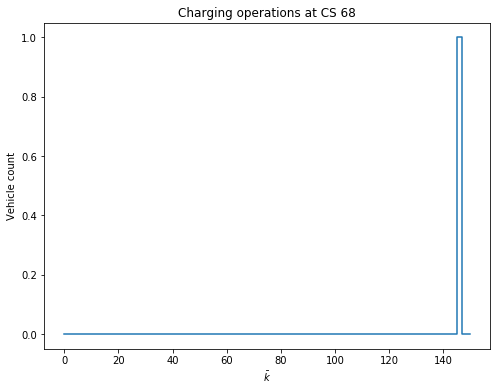

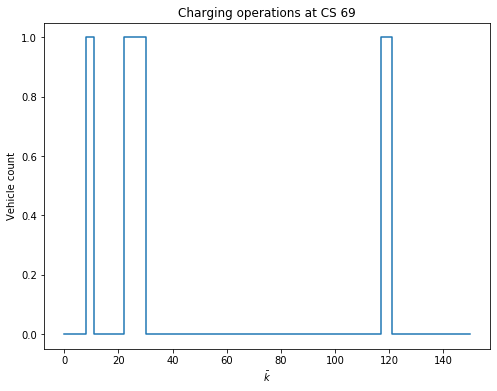

In [13]:
# %% Vehicles dynamics

# Vectors to plot

colorArrowTravel = 'SteelBlue'
colorArrowCharging = 'Crimson'
colorArrowServing = 'SeaGreen'

# Plot
maxTw = -1
minTw = 100000000000
for vehicleID, vehicle in vehiclesDict.items():
    # figures
    figX1 = figure(plot_width=600, plot_height=450,
                   title='Time the (vehicle '+str(vehicleID)+')',
                   toolbar_location=None)
    figX2 = figure(plot_width=600, plot_height=450,
                   title='SOC (vehicle '+str(vehicleID)+')',
                  y_range=(0, 100),
                  toolbar_location=None)
    figX3 = figure(plot_width=600, plot_height=450,
                   title='Payload (vehicle '+str(vehicleID)+')',
                  toolbar_location=None)
    
    # reaching leaving states for the vehicle
    reachingLeavingStates = leavingReachingSequences[vehicleID]

    # time windows
    nSeq = vehicle.nodeSequence
    kCustomers = []
    tWindowsUpper = []
    tWindowsLower = []
    for i, node in enumerate(nSeq):
        if networkDict[node].isCustomer():
            kCustomers.append(i)
            tWindowsCenter = (networkDict[node].timeWindowUp + networkDict[node].timeWindowDown) / 2.0
            tWindowsWidth =(networkDict[node].timeWindowUp - networkDict[node].timeWindowDown) / 2.0
            tWindowsUpper.append(tWindowsCenter + tWindowsWidth)
            tWindowsLower.append(tWindowsCenter - tWindowsWidth)
            # Time windows whiskers
            whiskerTW = Whisker(base=i, upper=tWindowsCenter + tWindowsWidth, lower=tWindowsCenter - tWindowsWidth)
            figX1.add_layout(whiskerTW)
            
            # update TW bounds
            if tWindowsCenter + tWindowsWidth > maxTw:
                maxTw = tWindowsCenter + tWindowsWidth
            if tWindowsCenter - tWindowsWidth < minTw:
                minTw = tWindowsCenter - tWindowsWidth
    
    # adjust fig 1 to fit TWs
    figX1.y_range=Range1d(minTw-10, maxTw+10)

    kVehicle = range(0, vehicle.si)

    figX1.line(kVehicle, reachingLeavingStates[0, :], alpha=0)
    figX1.line(kVehicle, reachingLeavingStates[1, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[2, :], alpha=0)
    figX2.line(kVehicle, reachingLeavingStates[3, :], alpha=0)
    figX3.line(kVehicle, reachingLeavingStates[4, :], alpha=0)

    reachingLeavingVectorPrev = reachingLeavingStates[:, 0]
    nodePrev = nSeq[0]
    kPrev = 0

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[0], y_offset=-5, text=str(node), text_baseline='top')
    figX1.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[2], y_offset=-5, text=str(node), text_baseline='top')
    figX2.add_layout(label)

    label = Label(x=kPrev, y=reachingLeavingVectorPrev[4], y_offset=-5, text=str(node), text_baseline='top')
    figX3.add_layout(label)
    
    # Axes
    figX1.xaxis.axis_label = 'k'
    figX1.yaxis.axis_label = 'Time of the day (min)'
    figX1.axis.axis_label_text_font_size = '15pt'
    figX1.axis.major_label_text_font_size = '13pt'
    figX1.title.text_font_size = '15pt'
    
    figX2.xaxis.axis_label = 'k'
    figX2.yaxis.axis_label = 'SOC (%)'
    figX2.axis.axis_label_text_font_size = '15pt'
    figX2.axis.major_label_text_font_size = '13pt'
    figX2.title.text_font_size = '15pt'
    
    figX3.xaxis.axis_label = 'k'
    figX3.yaxis.axis_label = 'Payload (ton)'
    figX3.axis.axis_label_text_font_size = '15pt'
    figX3.axis.major_label_text_font_size = '13pt'
    figX3.title.text_font_size = '15pt'
    
    # horizontal line SOC
    hline1 = Span(location=40, dimension='width', line_color='black')
    hline2 = Span(location=80, dimension='width', line_color='black')
    figX2.renderers.extend([hline1, hline2])
    
    
    for reachingLeavingVector, node, k in zip(reachingLeavingStates[:, 1:].T, nSeq[1:], range(1, vehicle.si)):
        # x1
        label = Label(x=k, y=reachingLeavingVector[0], y_offset=-5, text=str(node), text_baseline='top')
        figX1.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[1],
                            x_end=k, y_end=reachingLeavingVector[0],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
        else:
            colorArrowSpent = colorArrowServing

        arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[0],
                           x_end=k, y_end=reachingLeavingVector[1],
                           end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                           line_color=colorArrowSpent, line_alpha=1)

        figX1.add_layout(arrowTravel)
        figX1.add_layout(arrowSpent)

        # x2
        label = Label(x=k, y=reachingLeavingVector[3], y_offset=10, text=str(node), text_baseline='top')
        figX2.add_layout(label)

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[3],
                            x_end=k, y_end=reachingLeavingVector[2],
                            end=VeeHead(size=8, fill_color=colorArrowTravel, line_color=colorArrowTravel),
                            line_color=colorArrowTravel, line_alpha=1, line_width=1.5, visible=True)
        figX2.add_layout(arrowTravel)

        if networkDict[node].isChargeStation():
            colorArrowSpent = colorArrowCharging
            arrowSpent = Arrow(x_start=k, y_start=reachingLeavingVector[2],
                               x_end=k, y_end=reachingLeavingVector[3],
                               end=VeeHead(size=8, fill_color=colorArrowSpent, line_color=colorArrowSpent),
                               line_color=colorArrowSpent, line_alpha=1, line_width=1.5, visible=True)
            figX2.add_layout(arrowSpent)


        # x3
        label = Label(x=k, y=reachingLeavingVector[4], y_offset=-5, text=str(node), text_baseline='top')
        figX3.add_layout(label)

        if networkDict[nodePrev].isChargeStation():
            colorArrow = colorArrowCharging

        else:
            colorArrow = colorArrowTravel

        arrowTravel = Arrow(x_start=kPrev, y_start=reachingLeavingVectorPrev[4],
                            x_end=k, y_end=reachingLeavingVector[4],
                            end=VeeHead(size=8, fill_color=colorArrow, line_color=colorArrow),
                            line_color=colorArrow, line_alpha=1, line_width=1.5, visible=True)
        figX3.add_layout(arrowTravel)

        # common
        reachingLeavingVectorPrev = reachingLeavingVector
        nodePrev = node
        kPrev = k
        
    # Save
    export_png(figX1, filename=figureFolderPath+"x1_vehicle"+str(vehicleID)+".png")
    
    export_png(figX2, filename=figureFolderPath+"x2_vehicle"+str(vehicleID)+".png")
    
    export_png(figX3, filename=figureFolderPath+"x3_vehicle"+str(vehicleID)+".png")   
    
    
    # Show
    show(figX1)
    show(figX2)
    show(figX3)

# %% Plot results for CSs
for cs in networkDict['CS_LIST']:
    fig = plt.figure(figsize=(8, 6))
    csID = cs.id
    counter = thetaMatrix[csID, :]
    plt.step(np.arange(len(counter)), counter)
    plt.title('Charging operations at CS ' + str(csID))
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('Vehicle count')
    plt.savefig(figureFolderPath+"CS_"+str(cs.id)+".png")
    plt.show()


In [14]:
# %% Time of execution
tEnd = time.time()
print("Total execution time:", (tEnd - t0) * 1000.0, "ms")

Total execution time: 770667.9148674011 ms
